In [31]:
# import libraries and modules
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, GlobalMaxPool2D, Dense, Dropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = Path('/content/drive/MyDrive/MAID/502 CI/project/data')

In [4]:
train_data = pd.read_csv(data_dir / 'train' / 'annot_csv' / 'train.csv')
train_data.head()

,filename,label,xcenter,ycenter,width,height
0,image_1h3.png,whiteKing,203,151,26,26
1,image_2h4.png,blackQueen,203,125,26,26
2,image_1a5.png,whiteKing,21,99,26,26
3,image_3g2.png,whiteQueen,177,177,26,26
4,image_1f4.png,whiteKing,151,125,26,26


In [5]:
valid_data = pd.read_csv(data_dir / 'valid' / 'annot_csv' / 'valid.csv')
valid_data.head()

,filename,label,xcenter,ycenter,width,height
0,image_2h3.png,blackQueen,203,151,26,26
1,image_0h8.png,blackKing,203,21,26,26
2,image_1f1.png,whiteKing,151,203,26,26
3,image_0e4.png,blackKing,125,125,26,26
4,image_0c6.png,blackKing,73,73,26,26


In [6]:
label_to_class_names = {
    0: 'blackKing',
    1: 'whiteKing',
    2: 'blackQueen',
    3: 'whiteQueen',
}

In [7]:
class_names_to_label = {v: k for k, v in label_to_class_names.items()}

In [8]:
encode_classname = {
    'blackKing': [1, 0, 0, 0],
    'whiteKing': [0, 1, 0, 0],
    'blackQueen': [0, 0, 1, 0],
    'whiteQueen': [0, 0, 0, 1]
}

In [9]:
train_x = []
train_y_class = []
train_y_reg = []
for idx, row in train_data.iterrows():
    img_name = row.iloc[0]
    xcenter = row.iloc[2]
    ycenter = row.iloc[3]


    _stem = Path(img_name).stem
    label = int(_stem.split('_')[1][0])
    class_name = label_to_class_names[label]
    img_path = str(data_dir / "train" / 'images' / class_name / img_name)

    img = plt.imread(img_path)
    train_x.append(img)
    train_y_class.append(encode_classname[class_name])
    train_y_reg.append([xcenter, ycenter])

train_x = np.stack(train_x)
train_y_class = np.stack(train_y_class)
train_y_reg = np.stack(train_y_reg).astype(float)

In [10]:
train_x.shape, train_y_class.shape, train_y_reg.shape

((204, 224, 224, 3), (204, 4), (204, 2))

In [11]:
valid_x = []
valid_y_class = []
valid_y_reg = []
for idx, row in valid_data.iterrows():
    img_name = row.iloc[0]
    xcenter = row.iloc[2]
    ycenter = row.iloc[3]


    _stem = Path(img_name).stem
    label = int(_stem.split('_')[1][0])
    class_name = label_to_class_names[label]
    img_path = str(data_dir / "valid" / 'images' / class_name / img_name)

    img = plt.imread(img_path)
    valid_x.append(img)
    valid_y_class.append(encode_classname[class_name])
    valid_y_reg.append([xcenter, ycenter])

valid_x = np.stack(valid_x)
valid_y_class = np.stack(valid_y_class)
valid_y_reg = np.stack(valid_y_reg).astype(float)

In [12]:
valid_x.shape, valid_y_class.shape, valid_y_reg.shape

((52, 224, 224, 3), (52, 4), (52, 2))

In [13]:
train_y_reg[:5]

array([[203., 151.],
       [203., 125.],
       [ 21.,  99.],
       [177., 177.],
       [151., 125.]])

In [14]:
valid_y_reg[:5]

array([[203., 151.],
       [203.,  21.],
       [151., 203.],
       [125., 125.],
       [ 73.,  73.]])

In [15]:
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = GlobalMaxPool2D()(vgg.layers[-1].output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
op1 = Dense(4, activation='softmax')(x)
op2 = Dense(2, activation='linear')(x)

model = Model(vgg.inputs, [op1, op2])

58900480/58889256 [==============================] - 1s 0us/step


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [17]:
model.compile(
    optimizer=Adam(0.0001, clipvalue=100), 
    loss=['categorical_crossentropy', 'mse'],
    loss_weights=[5, 0.25]
)

In [18]:
check = ModelCheckpoint("model.hdf5", monitor='val_loss', verbose=1, save_best_only=True)

In [19]:
history = model.fit(
    train_x, 
    [train_y_class, train_y_reg],
    validation_data=(valid_x, [valid_y_class, valid_y_reg]),
    batch_size = 32, 
    epochs = 100, 
    callbacks = [check],
    verbose = 1
)

Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 3566.7136 - dense_2_loss: 5.0250 - dense_3_loss: 14166.3555
Epoch 00001: val_loss improved from inf to 1182.53955, saving model to model.hdf5
7/7 [==============================] - 44s 3s/step - loss: 3566.7136 - dense_2_loss: 5.0250 - dense_3_loss: 14166.3555 - val_loss: 1182.5396 - val_dense_2_loss: 25.0347 - val_dense_3_loss: 4229.4644
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 1397.1562 - dense_2_loss: 26.8074 - dense_3_loss: 5052.4766
Epoch 00002: val_loss improved from 1182.53955 to 987.07214, saving model to model.hdf5
7/7 [==============================] - 6s 919ms/step - loss: 1397.1562 - dense_2_loss: 26.8074 - dense_3_loss: 5052.4766 - val_loss: 987.0721 - val_dense_2_loss: 10.5862 - val_dense_3_loss: 3736.5649
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 1131.8962 - dense_2_loss: 18.1856 - dense_3_loss: 4163.8735
Epoch 00003: val_loss improved from 987.07214 to 9

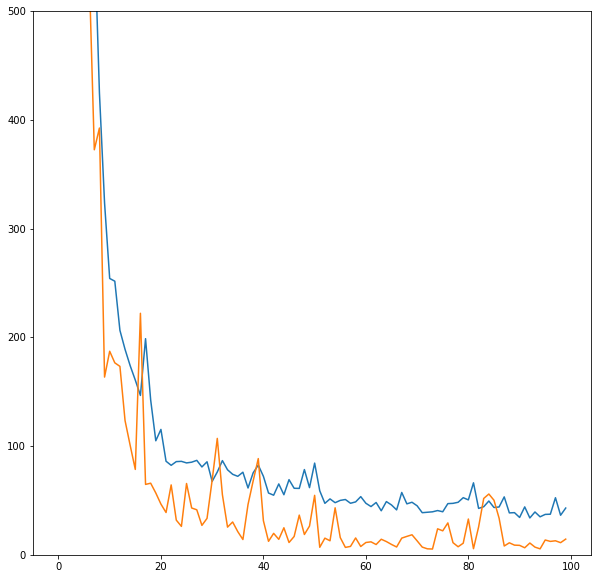

In [20]:
plt.figure(figsize=(10, 10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim(0, 500)

plt.show()

In [21]:
model.load_weights('model.hdf5')

In [22]:
pred_class, pred_reg = model.predict(valid_x)
pred_class[:5], pred_reg[:5]

(array([[9.7643846e-12, 4.0158678e-33, 1.0000000e+00, 2.7231967e-11],
        [9.9999976e-01, 4.9183102e-13, 6.4737492e-08, 1.4623420e-07],
        [1.7389263e-16, 1.0000000e+00, 1.9013007e-26, 2.3372250e-12],
        [9.9999893e-01, 2.3665814e-09, 1.1232881e-06, 1.4758951e-10],
        [9.9997163e-01, 1.2321541e-10, 2.8342576e-05, 2.8720276e-10]],
       dtype=float32), array([[212.74702 , 142.8202  ],
        [202.27634 ,  22.56296 ],
        [144.26714 , 195.12964 ],
        [126.380325, 123.83264 ],
        [ 75.64244 ,  75.30838 ]], dtype=float32))

In [24]:
xcenter, ycenter = pred_reg[0].astype(int).clip(0)
xcenter, ycenter

(212, 142)

In [23]:
pred_class[:5]

array([9.7643846e-12, 4.0158678e-33, 1.0000000e+00, 2.7231967e-11],
      dtype=float32)

In [25]:
label_to_class_names[np.argmax(pred_class[0])]

'blackQueen'

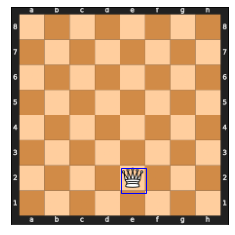

Label is whiteQueen


In [26]:
idx = np.random.randint(valid_x.shape[0])

fig, ax = plt.subplots()

ax.imshow(valid_x[idx])
xcenter, ycenter = pred_reg[idx].astype(int).clip(0)
rect = patches.Rectangle((xcenter - 26/2, ycenter - 26/2), 26, 26, linewidth=1, edgecolor='b', facecolor='none')
ax.add_patch(rect)

ax.set_xticks([])
ax.set_yticks([])

plt.show()
print('Label is', label_to_class_names[np.argmax(pred_class[idx])])

In [27]:
y_true = valid_y_class.argmax(axis=1)
y_true

array([2, 0, 1, 0, 0, 3, 3, 2, 3, 1, 1, 1, 2, 0, 3, 0, 1, 2, 1, 2, 1, 0,
       2, 3, 3, 0, 2, 1, 2, 0, 0, 0, 1, 2, 3, 3, 3, 3, 2, 3, 2, 1, 3, 3,
       2, 1, 1, 0, 0, 2, 1, 0])

In [28]:
y_pred = pred_class.argmax(axis=1)
y_pred

array([2, 0, 1, 0, 0, 3, 3, 2, 3, 1, 1, 1, 2, 0, 3, 0, 1, 2, 1, 2, 1, 0,
       2, 3, 0, 0, 2, 1, 2, 0, 0, 0, 1, 2, 3, 3, 3, 3, 2, 3, 2, 1, 3, 3,
       2, 1, 1, 0, 0, 2, 1, 0])

In [29]:
accuracy_score(y_true, y_pred)

0.9807692307692307

In [30]:
confusion_matrix(y_true, y_pred)

array([[13,  0,  0,  0],
       [ 0, 13,  0,  0],
       [ 0,  0, 13,  0],
       [ 1,  0,  0, 12]])

In [33]:
precision_score(y_true, y_pred, average='weighted')

0.9821428571428571

In [34]:
recall_score(y_true, y_pred, average='weighted')

0.9807692307692307